# Example Transient Simulation

Brute-force simulation of transients. Using actual observing conditions (bright/dark conditions, moon illumination and angle, seeing, etc.), pass a transient model through the detector simulation and generate a transient flux. Then add it to actual galaxies.

In [1]:
import os
import snxform

import numpy as np

from copy import copy
from urllib import request

from astropy.io import fits
from astropy.table import Table
from astropy import units as u

#- Necessary DESI pipeline files.
import desispec
from desispec.spectra import Spectra
from desispec.io import read_spectra, write_spectra
from desispec.coaddition import coadd, coadd_cameras, spectroperf_resample_spectra

#- Useful utilities for spectra.
from speclite import filters
rfilt = filters.load_filters('decam2014-r')

#- Detector simulation.
from desisim.scripts.quickspectra import sim_spectra

#- Use sncosmo as the transients library.
import sncosmo

import matplotlib.pyplot as plt

## Download EDR File

The DESI EDR data are available from a [public folder at NERSC](https://data.desi.lbl.gov/public/edr/).

We want the "cumulative" spectrum files labeled "spectra" in the `redux` folder, because these are not coadded across multiple nights of data taking.

In [2]:
def get_spectro_data(tile: int, night: int, petal: int) -> list[str, str]:
    """Access both the spectra and the redshifts for a given observation.
    """
    specfile = f'spectra-{petal}-{tile}-thru{night}.fits'
    redshift = f'redrock-{petal}-{tile}-thru{night}.fits'
    
    baseurl = f'https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles/cumulative/{tile}/{night}'
    if not (os.path.exists(specfile) and os.path.exists(redshift)):
        request.urlretrieve(os.path.join(baseurl, specfile), specfile)
        request.urlretrieve(os.path.join(baseurl, redshift), redshift)
    
    return specfile, redshift

In [3]:
specfile, redshift = get_spectro_data(96, 20210417, 4)

In [4]:
rfmap = Table.read(redshift, 'FIBERMAP')
zvals = Table.read(redshift, 'REDSHIFTS')

Read in the data from FITS, apply some basic target selection ([see here for details](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html)):
- No sky fibers (`OBJTYPE==TARGET`).
- `FIBERSTATUS` bit 0 (or 8).
- Bit 60 set in the `TARGET` bitmask (`BGS_ANY`).

In [5]:
def read_desi_spectra(specfile: str, redshift: str=None) -> desispec.spectra.Spectra:
    """Read in DESI EDR data and apply basic selections. Details of target masking are given in https://desidatamodel.readthedocs.io/en/latest/bitmasks.html.

    Parameters
    ----------
    specfile : str
        Path to FITS data containing DESI spectra.
    redshift : str or None
        Path to redshift data.
    
    Returns
    -------
    cspectra : desispec.spectra.Spectra
        Spectra object with coadded, selected fluxes.
    """
    #- Read the spectra. If there are separate 'b', 'r', and 'z' data, coadd them.
    spectra = read_spectra(specfile)
    if 'brz' in spectra.wave:
        cspectra = spectra
    else:
        cspectra = coadd_cameras(spectra)

    #- Access the FIBERMAP and EXP_FIBERMAP to apply selections.
    fmap = cspectra.fibermap
    expfmap = cspectra.exp_fibermap

    #- Select science targets, not SKY fibers.
    select  = (fmap['OBJTYPE'] == 'TGT')

    #- Good fibers have FIBERSTATUS 0 or bit 8 set (MISSINGPOSITION).
    #- Be careful to check for multiple exposures in a night.
    expids = np.unique(cspectra.exp_fibermap['EXPID'])
    nexp = expids.shape[0]
    if nexp > 1:
        for expid in expids:
            selexp = expfmap['EXPID'] == expid
            select &= (expfmap['FIBERSTATUS'][selexp] == 0) | (expfmap['FIBERSTATUS'][selexp] == 1<<3)
    else:
        select &= (expfmap['FIBERSTATUS'] == 0) | (expfmap['FIBERSTATUS'] == 1<<3)

    #- Select targets with BGS_ANY bit (bit number 60) set.
    targetbits = np.zeros_like(select, dtype=bool)
    for col in fmap.columns:
        if col.endswith('DESI_TARGET'):
            targetbits |= (fmap[col] & 1<<60 > 0)
    select &= targetbits
    
    #- If a redshift file is specified, add it as an extra table.
    if redshift is not None:
        zvals = Table.read(redshift, 'REDSHIFTS')
        cspectra.extra_catalog = zvals

    #- Apply the section to the spectra.
    return spectra[select], cspectra[select]

In [6]:
spectra, cspectra = read_desi_spectra(specfile, redshift)

INFO:spectra.py:391:read_spectra: iotime 0.446 sec to read spectra-4-96-thru20210417.fits at 2024-05-21T11:34:15.405822


## Select Spectra + Transients

Grab all objects in this file identified with $z<1$ by the pipeline.

In [7]:
ztab = cspectra.extra_catalog
zselect = (ztab['ZWARN']==0) & (ztab['DELTACHI2'] >= 25) & (ztab['SPECTYPE']=='GALAXY') & (ztab['Z'] < 0.1)
ztab[zselect]

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64
39633419130372718,0.09962796658315337,7.372646498752462e-06,0,7569.183263063431,505.3710084113758 .. -10.312279945050243,7892,GALAXY,--,10,984.8220856422558
39633419126180144,0.07764881622436783,4.162472890550265e-06,0,8330.028103232384,2014.9077210391943 .. -19.061907421101797,7908,GALAXY,--,10,3124.3205574816093
39633416332773557,0.07466068281242166,1.1119793333974573e-05,0,7904.624662540853,180.53213174795584 .. -38.23437928642948,7910,GALAXY,--,10,538.2372592464089
39633413518396096,0.07554692982959754,6.090292374882114e-06,0,13556.578722685575,-580.2950021650696 .. -245.34131529611196,7915,GALAXY,--,10,9356.987622997724
39633413518395569,0.0792542538952669,2.7285304028437e-06,0,9183.2914737463,3175.057354424323 .. 86.2692394738691,7888,GALAXY,--,10,14185.176486611366


### Access Exposure Data

This is the [EDR "fuji" CSV tile table](https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/exposures-fuji.csv) with some additional fields added, such as moon illumination and position.

Note that only the SV3 exposures are in the table.

In [8]:
exptab = Table.read('../../python/snxform/etc/exposures-fuji-sv3.ecsv')
exptab

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS
int64,int64,int64,float64,float64,float64,str3,str6,str6,str9,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210405,83522,12,150.04,2.286,59310.11613139,sv3,bright,bright,sv3bright,1087.2,1.9,220.0,bright,0.9,1.268,0.021,1.242,2.0,0.2,0.1,0.1,0.2,13.7,19.4,4.0,36.2,1.8,1.8,1.9,2.4,1.7,2.1,2.7,0.074,1.275,0.469,0.351,0.164,0.058,0.06,0.061,1.248,20.186,20.865,20.254,19.24,1.9,1.8,1.9,1.8,150.045192,2.27918,0.32165655238961327,169.97905325303662,151.56973009087207,1.2810781090848906,0.07630297572569356,20.198798889675196,0.46873832443347047,0.3516396983470239,0.1651608369709665
20210405,83524,23,150.04,2.286,59310.14064081,sv3,backup,backup,sv3backup,599.5,78.3,30.0,backup,0.9,1.198,0.021,1.38,60.9,7.3,1.8,5.0,4.6,473.4,685.3,135.5,1068.3,61.8,62.7,66.3,52.7,59.3,71.2,78.3,0.496,1.35,0.455,0.343,0.162,0.367,0.381,0.39,1.191,20.813,21.932,20.931,19.31,62.3,61.6,66.2,62.3,150.043079,2.27986,0.3195127315941897,169.89455362051018,151.82971360831672,1.3502111085861985,0.4949112245181938,20.813134188185895,0.45563334242062536,0.34348071784597145,0.1618446000838954
20210405,83525,50,179.599,0.12,59310.15083031,sv3,backup,backup,sv3backup,341.8,80.9,30.0,backup,0.9,1.588,0.024,1.727,61.4,8.1,2.0,5.5,3.7,521.6,737.5,143.9,1103.6,67.9,69.7,73.0,42.1,63.8,75.6,80.9,1.075,1.66,0.337,0.268,0.13,0.592,0.644,0.679,1.573,20.822,21.899,20.941,19.119,77.9,76.7,90.8,77.9,179.609871,0.11016,0.3186583197238284,168.70318022166424,127.59868646861702,1.660374806192365,1.0761869196764768,20.82199234836667,0.3366545120437453,0.267556737254928,0.12978446958949902
20210405,83526,39,179.599,0.12,59310.15691424,sv3,bright,bright,sv3bright,491.1,209.6,220.0,bright,0.9,1.535,0.024,1.446,224.0,23.5,5.8,16.2,14.0,1497.4,2246.4,424.7,2974.7,199.3,201.9,209.6,160.4,194.5,223.1,218.0,1.116,1.331,0.441,0.334,0.158,0.822,0.845,0.862,1.515,20.858,21.914,20.991,19.174,245.8,224.7,245.8,242.6,179.608859,0.110619,0.3179765407221857,167.4098187492401,127.67073102354172,1.330533503691481,1.1153485366408546,20.857570201417026,0.4400457924534194,0.3332921706256655,0.15740177096643126
20210405,83527,66,183.106,0.12,59310.16505076,sv3,bright,bright,sv3bright,572.3,178.2,220.0,bright,0.9,1.549,0.022,1.56,219.9,20.0,4.9,13.7,11.6,1273.0,1892.2,361.2,2612.6,169.3,171.7,178.2,133.0,163.8,189.7,191.5,1.06,1.483,0.393,0.303,0.144,0.66,0.703,0.73,1.524,20.87,21.893,21.005,19.254,215.3,192.4,215.3,186.9,183.116122,0.110499,0.31712639902081186,165.51623410615218,124.72309295033482,1.4840753679720609,1.0622639276830679,20.869874103784944,0.39216656696930385,0.3020814663922581,0.1441418043133455
20210405,83528,93,189.944,61.918,59310.17592541,sv3,bright,bright,sv3bright,1080.6,4.6,220.0,bright,0.9,1.321,0.013,1.452,4.1,0.5,0.1,0.4,0.7,32.9,43.2,8.8,80.3,4.3,4.5,4.6,7.5,3.7,4.6,5.9,0.085,1.039,0.574,0.413,0.189,0.074,0.073,0.073,1.304,20.13,21.409

Extract the observing conditions in the exposure table for the given tile and night.

In [9]:
tileid, night = [np.unique(cspectra.exp_fibermap[_])[0] for _ in ['TILEID', 'NIGHT']]

exposure_data = exptab[(exptab['TILEID'] == tileid) & (exptab['NIGHT'] == night)]
obsdict = {
    'SEEING'   : np.average(exposure_data['FWHM_ASEC']),
    'EXPTIME'  : np.sum(exposure_data['EXPTIME']),
    'AIRMASS'  : np.average(exposure_data['AIRMASS']),
    'MOONFRAC' : np.average(exposure_data['MOON_ILLUMINATION']),
    'MOONALT'  : np.average(exposure_data['MOON_ZD_DEG']),
    'MOONSEP'  : np.average(exposure_data['MOON_SEP_DEG']),
}

program = exposure_data['PROGRAM'][0]

obsdict, program

({'SEEING': 1.0539937154629542,
  'EXPTIME': 324.9,
  'AIRMASS': 1.156,
  'MOONFRAC': 0.3074972080265049,
  'MOONALT': 84.8066646822632,
  'MOONSEP': 69.48445442830277},
 'bright')

Exposure data for our particular selection.

In [10]:
exposure_data

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA,SKYRA,SKYDEC,MOON_ILLUMINATION,MOON_ZD_DEG,MOON_SEP_DEG,FWHM_ASEC,TRANSPARENCY,SKY_MAG_AB,FIBER_FRACFLUX,FIBER_FRACFLUX_ELG,FIBER_FRACFLUX_BGS
int64,int64,int64,float64,float64,float64,str3,str6,str6,str9,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210417,85196,96,189.69,61.868,59322.27921726,sv3,bright,bright,sv3bright,324.9,226.3,220.0,bright,0.9,1.156,0.013,1.098,254.7,26.3,6.1,17.6,13.8,1616.1,2352.6,444.7,2925.6,216.8,226.0,226.3,157.3,203.7,233.6,214.4,1.052,1.054,0.578,0.415,0.191,0.989,0.972,0.969,1.157,21.161,21.882,21.176,19.496,224.0,210.5,224.0,261.5,189.688371,61.87373,0.3074972080265049,84.8066646822632,69.48445442830277,1.0539937154629542,1.049430542114513,21.16101390514425,0.5782347167616813,0.4150192856288871,0.19041729739585544


### Transient Detector Simulation

Extract the redshifts for the transients we want to simulate.

We're going to then scale the transient flux in the r band to the observed spectra. This is just a simple number, which we can use to manage things like the brightness of the source, offsets of the source from the center of the fiber, etc. I.e., anything that can change the relative brightness of source and galaxy.

In [11]:
targetid = ztab['TARGETID'][zselect]
z = ztab['Z'][zselect]
sp = ztab['SPECTYPE'][zselect]
sb = ztab['SUBTYPE'][zselect]
if np.ma.is_masked(sb):
    sb = np.full_like(sb, '')
coeff = ztab['COEFF'][zselect]

In [12]:
wave = cspectra.wave['brz']
flux = cspectra.flux['brz']
ivar = cspectra.ivar['brz']

#### Galaxy Flux Normalization

Zero-pad the galaxy spectra so that we can compute the r-band flux using the DECam r filter in speclite. The particular filter isn't super important, as we care more about the galaxy-transient flux ratio...

In [13]:
pad_below = np.arange(wave[0]-0.8, 3300-0.8, -0.8)[::-1]
i = len(pad_below)
j = i + len(wave)
pad_above = pad_above = np.arange(wave[-1]+1, 10991)
wave_padded = np.concatenate([pad_below, wave, pad_above]) *u.Angstrom

nf, nw = np.sum(zselect), len(wave_padded)
flux_padded = np.zeros((nf, nw))
flux_padded[:, i:j] = flux[zselect]
flux_padded = flux_padded * 1e-17 * u.erg/(u.cm**2 * u.s * u.Angstrom)

In [14]:
galnorm = rfilt.get_ab_maggies(flux_padded, copy(wave_padded))['decam2014-r']
galnorm

6.057280743320338e-09
2.4932230779364344e-08
8.027352046346736e-09
5.509783528006219e-08
3.406620474303335e-08


#### Transient Flux Normalization

Generate an r-band flux normalization for a transient model, similar to what we did for the galaxy.

In this case, we'll simulate a SN Ia at max light, at the redshift of the underlying spectrum (according to the pipeline). We are ignoring extinction, but we don't care for now.

In [15]:
model = sncosmo.Model('hsiao')
wavemodel = np.arange(3300, 10991)

nf, nw = np.sum(zselect), len(wavemodel)
fluxmodel = np.zeros((nf, nw))

for k, z in enumerate(ztab['Z'][zselect]):
    model.set(z=z, t0=0)
    fluxmodel[k] = model.flux(0, wavemodel)
    
trnnorm = rfilt.get_ab_maggies(fluxmodel, copy(wavemodel))['decam2014-r']

In [16]:
trnnorm

1.03479730561199
0.995545030314538
0.9912744780401076
0.9925294339551556
0.9979168753302601


Scale the transient spectrum to the galaxy spectrum using the r-band normalization.

In [17]:
scale = 0.9

trafactor = galnorm / trnnorm * scale
fluxmodel = fluxmodel * trafactor[:, np.newaxis]

In [18]:
trafactor

5.268232376933181e-09
2.2539420134856588e-08
7.2882102805634324e-09
4.996129087522502e-08
3.072358532726811e-08


### Run the Detector Simulation

Pass the transient model to the quick spectral simulation, using the observing conditions of this exposure.

In [19]:
sim_spectra(wavemodel,
            fluxmodel*1e17,
            program='bright',
            obsconditions=obsdict,
            targetid=ztab['TARGETID'][zselect],
            spectra_filename='test.fits')

INFO:quickspectra.py:104:sim_spectra: Starting simulation of 5 spectra
INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.0539937154629542
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 324.9
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.156
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.3074972080265049
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = 84.8066646822632
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 69.48445442830277
DEBUG:simexp.py:490:simulate_spectra: running simulation with fastsim fiber loss method
DEBUG:simexp.py:496:simulate_spectra: source types: 5 sta

### Merge Spectra

Read in the generated spectra. They will be formatted as a `Spectra` object with fluxes broken out into the b, r, and z bands.

We will resample back to the wavelength grid of the data and then add the spectra.

In [20]:
simspec = read_spectra('test.fits')

INFO:spectra.py:391:read_spectra: iotime 0.018 sec to read test.fits at 2024-05-21T11:34:22.717343


In [21]:
simspec.wave

{'b': array([3569., 3570., 3571., ..., 5947., 5948., 5949.]),
 'r': array([5625., 5626., 5627., ..., 7739., 7740., 7741.]),
 'z': array([7435., 7436., 7437., ..., 9832., 9833., 9834.])}

In [22]:
a = cspectra[zselect]
b = spectroperf_resample_spectra(simspec, wave, nproc=8)

INFO:coaddition.py:1090:spectroperf_resample_spectra: waiting for the 8 processes to finish ...
INFO:coaddition.py:1093:spectroperf_resample_spectra: all done!


In [23]:
wave_tot = a.wave['brz']
flux_tot = { 'brz' : a.flux['brz'] + b.flux['brz'] }

w1 = a.ivar['brz']
w2 = b.ivar['brz']

ivar_tot = { 'brz' : w1*w2 / (scale*w2 + (1-scale)*w1) }

mask_tot = a.mask
res_tot = a.resolution_data

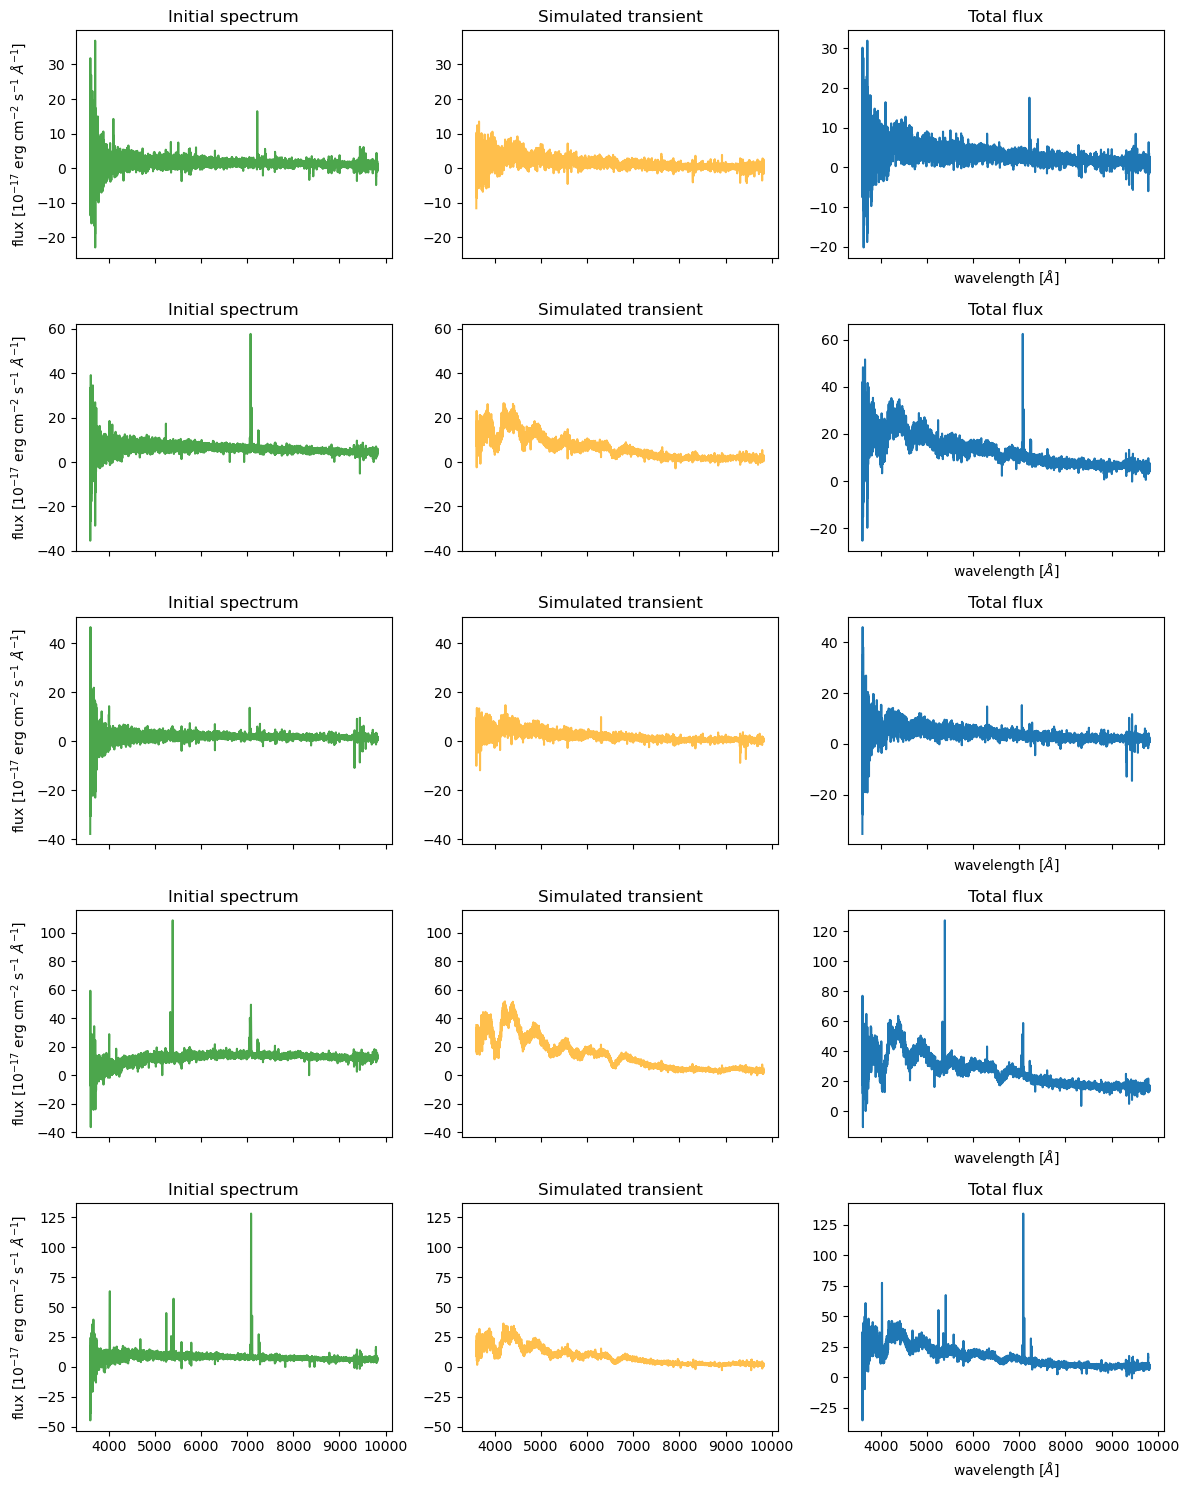

In [24]:
fig, axes = plt.subplots(b.num_spectra(), 3, figsize=(12,3*b.num_spectra()), sharex=True, tight_layout=True)

for i in range(b.num_spectra()):
    ax = axes[i][0]
    ax.plot(a.wave['brz'], a.flux['brz'][i], color='green', alpha=0.7)
    ax.set(title='Initial spectrum',
           ylabel=r'flux [10$^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
    ylim = ax.get_ylim()
    
    ax = axes[i][1]
    ax.plot(b.wave['brz'], b.flux['brz'][i], color='orange', alpha=0.7)
    ax.set(ylim=ylim)
    ax.set(title='Simulated transient')
    
    ax = axes[i][2]
    ax.plot(b.wave['brz'], flux_tot['brz'][i])
    ax.set(title='Total flux',
           xlabel=r'wavelength [$\AA$]')